<div class="alert alert-block alert-success" style="font-size:30px">
🧬 NESP: ThermoNet v2 🧬
</div>

<div class="alert alert-block alert-danger" style="text-align:center; font-size:20px;">
    ❤️ Dont forget to ▲upvote▲ if you find this notebook usefull!  ❤️
</div>

This notebook implements a set of incremental improvements on top of the [NESP: ThermoNet notebook](https://www.kaggle.com/code/vslaykovsky/nesp-thermonet). It is largely inspired by the work of Bian Li,Yucheng T. Yang,John A. Capra ,Mark B. Gerstein: [Predicting changes in protein thermodynamic stability upon point mutation with deep 3D convolutional neural networks](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008291)
Official ThermoNet repository can be found here: https://github.com/gersteinlab/ThermoNet


## Results

Here is a comparison between ThermoNet and ThermoNet2 models. First column shows performance of a simple ensemble built on cross-validate folds. The second column adds best public notebooks to the ensemble. 



| Model | <div style="width:300px">LB: Base model (10 folds)</div> | <div style="width:300px">LB: 10 folds + public notebooks ensemble</div> |
| :- | :- | :- |
| ThermoNet2 | **0.494** | **0.582** |
| [ThermoNet](https://www.kaggle.com/code/vslaykovsky/nesp-thermonet) | 0.4 | 0.483 |




## Improvements in v2 over v1

Here are main differences with the baseline ThermoNet model:
* **Larger training set (3214 -> 14656)**. This model uses the output of "[**NESP: 14656 Unique Mutations + Voxel Features**](https://www.kaggle.com/vslaykovsky/nesp-9936-unique-mutations-voxel-features)" notebook wich is AFAIK the largest dataset so far.
* The model was trained using only **destabilizing mutations** ($\Delta \Delta G < 0$). This improved performance by a few percentage points. It seems like NESP test dataset is generated from more or less random mutations of the wildtype protein. It usually means that the majority of such mutations are destabilizing. Note: in this notebook we use the following signs of targets for destabilizing mutations: $\Delta \Delta G < 0$ and/or $\Delta T < 0$. In other literature you might find different notations. 
* The model was rewritten to **PyTorch**. 
* Capacity of the model was increased - added **more convolutional layers**. This improved performance, likely thanks to larger dataset.
* **Auxilliary target $\Delta T$**. The "[NESP: 14656 Unique Mutations + Voxel Features](https://www.kaggle.com/vslaykovsky/nesp-9936-unique-mutations-voxel-features)" dataset contains both $\Delta \Delta G$ and $\Delta T$ targets. Targets are strongly correlated with each other. So it makes sense to use both targets to train the backbone of the network while keeping separate fully-connected heads to account for different distributions between targets. Specifically, the training loss used in this notebook is $\mathcal L= (y_{\Delta \Delta G} - \hat{y}_{\Delta \Delta G})^2 + C * (y_{\Delta T} - \hat{y}_{\Delta T})^2$, where $C=0.01$ is a hyperparameter that defines contribution of the $\Delta T$ loss.
* **Improved training features**. In the baseline ThermoNet model samples are generated with a simple concatenation of 7 voxel features calculated for each of wildtype and mutant proteins. It results in `concat(7x16x16x16, 7x16x16x16) == 14x16x16x16` shape (16 voxels in every direction, 14 channels per voxel). In this notebook we hypothesise that targets depend on the shape of the difference between voxel features of wildtype and mutant residues and significant part of learned logic in CNN layers is dedicated to calculating this difference. So we simplify this task by providing **differential features** along with normal ones. E.g. `difference_features = features[7:] - features[..., :7]`
* **Hyperparameter optimization** with Optuna and Wandb sweeps. Best version is stored to `BEST_PARAMS` constant.


## How does ThermoNet v2 work?

ThermoNet v2 is a 3D CNN with features generated from 3D structures of wildtype and mutant proteins. This is done in 3 steps: 

1. Accurate 3D structures of mutant proteins are generated from the wildtype template. In the paper authors use Rosetta "FastRelax" protocol to generate mutant PDB files. You can find this logic in "[NESP: 14656 Unique Mutations + Voxel Features](https://www.kaggle.com/vslaykovsky/nesp-9936-unique-mutations-voxel-features)". I generated all structures on my laptop, because It's close to impossible to recreate such PDB files in Kaggle boxes:
    * It takes a lot of time. I generated test PDBS in ~10 hours on my 16 core laptop. 
    * Rosetta comes with a license that prohibits its redistribution. So you'll have to download and acquire free academic license by yourself in order to use Rosetta.

2. Now once we have all PDB structures, voxel features are generated from them. This is done with `Acellera htmd` library. Voxel features include a set of 7 attributes packed into a grid of size (16, 16, 16). 7 features names are: `'hydrophobic', 'aromatic', 'hbond_acceptor', 'hbond_donor', 'positive_ionizable', 'negative_ionizable', 'occupancies'`. For each training sample features come from both wildtype and mutant PDBs, so the final shape of each sample is: (14, 16, 16, 16)

<img src="https://images2.imgbox.com/7c/5d/9mzuGf8N_o.png" alt="image host"/>

3. Finally a simple VGG-style CNN is used to train the regression model. An ensemble of 10 models is used to predict the score. Only  $\Delta \Delta G$ output is used in prediction, $\Delta T$ is only used in training as a part of the loss function. 


### Architecture of the model:

<img src="https://images2.imgbox.com/1d/e9/UZ0tpNPy_o.png" alt="image host"/>


## Additional notes
* **[Didn't work]** Using $\Delta T$ as the main target and $\Delta \Delta G$ as an auxilliary target. Perhaps there are too few $\Delta T$ data in the training set. 
* The notebook is divided into sections. Each section can be enabled with it's own flag (TRAIN, OPTUNA, WANDB_SWEEP, SUBMISSION). All flags are defined in the "Utils, imports" section

# Utils, imports

In [1]:
import multiprocessing
import os

import Levenshtein
import numpy as np
from plotly.offline import init_notebook_mode
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm

init_notebook_mode(connected=True)
import glob
from scipy.stats import spearmanr
from pprint import pprint

import plotly.express as px
import torch as th
import pandas as pd
from scipy.stats import rankdata
import json
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from collections import defaultdict
import copy
from torch.optim import AdamW

MULTIPROCESSING = False
BOXSIZE = 16
VOXELSIZE = 1
N_FOLDS = 10
MODELS_PATH = 'models'
DEBUG = True
DEVICE = 'cuda' if th.cuda.is_available() else 'cpu'
DESTABILIZING_MUTATIONS_ONLY = True
AUGMENT_DESTABILIZING_MUTATIONS = False
EARLY_STOPPING_PATIENCE = 30
IS_DDG_TARGET = True
WITH_PUCCI_SOURCE = True
WITH_KAGGLE_DDG_SOURCE = True

# switchers
TRAIN = False
WANDB_TRAIN_PROJECT = 'ThermoNetV2-train'
WANDB_TRAIN_NAME = 'thermonetv2-7633-v2'

OPTUNA = False
OPTUNA_WANDB_PROJECT = "ThermoNetV2-Optuna"
OPTUNA_TRIALS = 400

WANDB_SWEEP = False
WANDB_SWEEP_PROJECT = 'ThermoNetV2-sweep'

SUBMISSION = True


DEFAULT_PARAMS = {
    'SiLU': False,
    'diff_features': True,
    'LayerNorm': False,
    'GroupKFold': False,  # only use for hyperopt
    'epochs': 30,
    'AdamW': False,
}





BEST_PARAMS = {**DEFAULT_PARAMS, **{'AdamW': True,
 'C_dt_loss': 0.01,
 'OneCycleLR': False,
 'batch_size': 256,
 'AdamW_decay': 1.3994535042337082,
 'dropout_rate': 0.06297340526648805,
 'learning_rate': 0.00020503764745082723,
 'conv_layer_num': 5,
 'dropout_rate_dt': 0.3153179929570238,
 'dense_layer_size': 74.1731281147114}}



try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    WANDB_API_KEY = user_secrets.get_secret("WANDB_API_KEY")

    print('Running in Kaggle')
    WILDTYPE_PDB = '../input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb'
    PDB_PATH = '../input/thermonet-wildtype-relaxed'
    TRAIN_FEATURES_PATH = '../input/thermonet-features/Q3214.npy'
    TRAIN_TARGETS_PATH = ''
    TEST_CSV = '../input/novozymes-enzyme-stability-prediction/test.csv'
    TEST_FEATURES_PATH = '../input/thermonet-features/nesp_features.npy'
    PUBLIC_SUBMISSIONS=[
        '../input/rmsd-from-molecular-dynamics/submission_rmsd.csv',     # LB: 0.507
        '../input/plldt-ddg-demask-sasa/deepddg-ddg.csv',                # LB: 0.451
        '../input/novo-esp-eli5-performant-approaches-lb-0-451/submission.csv',  # 0.451
        '../input/nesp-alphafold-getarea-exploration/submission.csv',                   # 0.407
    ]    
    TRAIN_FEATURES_DIR = '../input/nesp-9936-unique-mutations-voxel-features'
    

except Exception as ex:
    print('Running locally')
    WILDTYPE_PDB = 'nesp/thermonet/wildtypeA.pdb'
    PDB_PATH = 'nesp/thermonet/'
    TRAIN_FEATURES_PATH = 'data/train_features/features.npy'
    TRAIN_TARGETS_PATH = 'data/train_features/dataset.csv'
    TEST_FEATURES_PATH = 'data/nesp/nesp_features.npy'
    TEST_CSV = 'data/nesp/test.csv'
    PUBLIC_SUBMISSIONS=glob.glob('data/nesp/public_submissions/*.csv')
    TRAIN_FEATURES_DIR = 'data/train_features/'
    WANDB_API_KEY='your_key_here'

os.makedirs(MODELS_PATH, exist_ok=True)

Running in Kaggle


In [2]:
import wandb

"""
Add WANDB_API_KEY with your wandb.ai API key to run the code. 
"""
wandb.login(key=WANDB_API_KEY)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Load training data

In [3]:
def load_data():
    print("1. Loading csv datasets")
    df = pd.read_csv(f'{TRAIN_FEATURES_DIR}/dataset.csv')
    df.source = df.source.apply(eval)
    print(f'Total unique mutations: {len(df)}')

    df['features'] = df.apply(lambda r: f'{TRAIN_FEATURES_DIR}/features/{r.PDB_chain}_{r.wildtype}{r.pdb_position}{r.mutant}.npy', axis=1)
    df = df[df.features.apply(lambda v: os.path.exists(v))]

    print(f'Total mutations with features: {len(df)}')

    if not WITH_PUCCI_SOURCE:
        df = df[df.source.apply(lambda v: v != ['pucci-proteins-appendixtable1.xlsx'])]

    if not WITH_KAGGLE_DDG_SOURCE:
        df = df[df.source.apply(lambda v: v != ['ddg-xgboost-5000-mutations-200-pdb-files-lb-0-40.csv'])]

    print(f'Total mutations after filtering: {len(df)}')

    df.features = [np.load(f) for f in tqdm(df.features, desc="2. Loading features")]


    df_train = df

    if DESTABILIZING_MUTATIONS_ONLY:
        print('Keeping destabilizing mutations only')
        df_train = df_train[((df_train.ddG < 0))  & ((df_train.dT < 0) | df_train.dT.isna())].reset_index(drop=True).copy() # best for ddG
    elif AUGMENT_DESTABILIZING_MUTATIONS:
        print('Augmenting destabilizinb mutations')
        df_pos = df_train[df_train.ddG > 0].copy()
        df_neg = df_train[df_train.ddG < 0]
        print(df_pos.shape, df_neg.shape)
        df_pos.features = df_pos.features.apply(lambda f: np.concatenate([f[7:], f[:7]], axis=0))
        df_pos.ddG = -df_pos.ddG
        df_pos.dT = -df_pos.dT
        df_train = pd.concat([df_pos, df_neg], axis=0).sample(frac=1.).reset_index(drop=True)        
    return df_train

df_train = load_data()
df_train

1. Loading csv datasets
Total unique mutations: 14656
Total mutations with features: 12167
Total mutations after filtering: 12167


2. Loading features:   0%|          | 0/12167 [00:00<?, ?it/s]

Keeping destabilizing mutations only


,sequence,wildtype,pdb_position,seq_position,mutant,ddG,dT,wT,pH,source,PDB_chain,features
0,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,D,58,58,N,-0.120000,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA,[[[[1.00000000e+00 1.83487193e-01 3.07613411e-...
1,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,E,25,25,A,-0.050000,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA,[[[[3.38143335e-06 3.03279778e-05 3.04589878e-...
2,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,R,23,23,A,-0.763333,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA,[[[[0.00000000e+00 0.00000000e+00 0.00000000e+...
3,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,R,39,39,A,-0.726667,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA,[[[[0.0076158 0.09321734 0.13197631 0.0698161...
4,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,R,47,47,A,-0.636429,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA,[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
...,...,...,...,...,...,...,...,...,...,...,...,...
7628,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,R,382,269,S,-17.400000,-5.2,NaN,7.4,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1clwA,[[[[0.00544725 0.06888345 0.3927299 0.1319893...
7629,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,T,235,122,I,-1.600000,-0.4,NaN,7.4,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1clwA,[[[[6.02426507e-04 2.46603597e-03 4.25419226e-...
7630,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,G,244,131,R,-1.330000,NaN,NaN,7.4,"[dataset_S2648.csv, iStable2.0 - s3568]",1tyvA,[[[[3.29420297e-02 1.07765760e-01 2.73649860e-...
7631,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,R,285,172,K,-3.430000,NaN,NaN,7.4,"[dataset_S2648.csv, iStable2.0 - s3568]",1tyvA,[[[[2.24163487e-03 1.26180000e-02 7.25209257e-...


<AxesSubplot:title={'center':'Distribution of dT'}, ylabel='Frequency'>

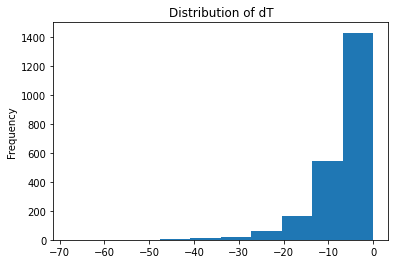

In [4]:
df_train.dT.plot.hist(title='Distribution of dT')

<AxesSubplot:title={'center':'Distribution of ddG'}, ylabel='Frequency'>

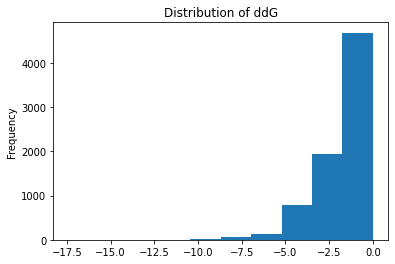

In [5]:
df_train.ddG.plot.hist(title='Distribution of ddG')

<AxesSubplot:title={'center':'ddG vs dT'}, xlabel='ddG', ylabel='dT'>

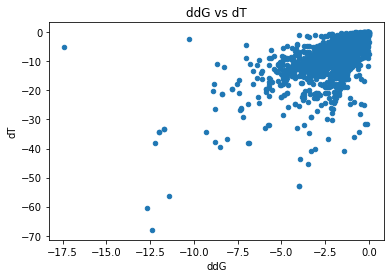

In [6]:
df_train.plot.scatter(x='ddG', y='dT', title='ddG vs dT')

<AxesSubplot:title={'center':'Mutations per sequence'}, ylabel='Frequency'>

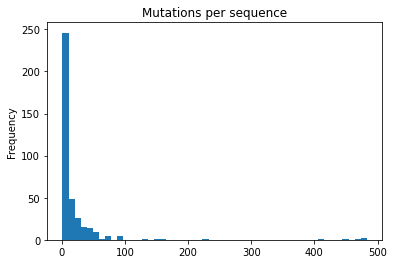

In [7]:
df_train.groupby('sequence').features.count().plot.hist(title='Mutations per sequence', bins=50)

# Plotting voxel representation of features

In the following plots we use 3D scatterplot to demonstrate training samples. 
Specifically we plot `occupancy` feature that represents probability that certain voxel is occpupied by an atom.
Recall that each training/test sample uses a combination of wildetype+mutant features. So we use the following color-coding:
* blue color represents voxels that are occupied in both wildtype and mutant structures 
* red color represents voxels that are occupied only in the mutant structure
* green color represents voxels that are occupied only in the wildtype structure

In [8]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

def plot_voxels():
    for i in [123, 124, 125, 126]:
        df = pd.DataFrame([(x, y1, z) for x in range(16) for y1 in range(16) for z in range(16)], columns=['x', 'y', 'z'])
        df['occupancy1'] = df_train.iloc[i].features[6, :, :, :].flatten() > 0.9
        df['occupancy2'] = df_train.iloc[i].features[13, :, :, :].flatten() > 0.9
        df.loc[df.occupancy1 | df.occupancy2, 'color'] = 'blue'
        df.loc[~df.occupancy1 & df.occupancy2, 'color'] = 'red'
        df.loc[df.occupancy1 & ~df.occupancy2, 'color'] = 'green'
        ddg = df_train.ddG[i]
        fig = px.scatter_3d(df.dropna(), x='x', y='y', z='z', color='color', title=f"Train idx:{i}; ddg={ddg}")
        fig.show()
        

plot_voxels()

# Model

In [9]:
class ThermoNet2(th.nn.Module):
    def __init__(self, params):
        super().__init__()

        CONV_LAYER_SIZES = [14, 16, 24, 32, 48, 78, 128]
        FLATTEN_SIZES = [0, 5488, 5184, 4000, 3072, 2106, 1024]

        dropout_rate = params['dropout_rate']
        dropout_rate_dt = params['dropout_rate_dt']
        dense_layer_size = int(params['dense_layer_size'])
        layer_num = int(params['conv_layer_num'])
        silu = params['SiLU']

        self.params = params
        if silu:
            activation = th.nn.SiLU()
        else:
            activation = th.nn.ReLU()

        model = [
            th.nn.Sequential(
                *[th.nn.Sequential(
                    th.nn.Conv3d(in_channels=CONV_LAYER_SIZES[l], out_channels=CONV_LAYER_SIZES[l + 1], kernel_size=(3, 3, 3)),
                    activation
                ) for l in range(layer_num)]
            ),
            th.nn.MaxPool3d(kernel_size=(2,2,2)),
            th.nn.Flatten(),
        ]
        flatten_size = FLATTEN_SIZES[layer_num]
        if self.params['LayerNorm']:
            model.append(th.nn.LayerNorm(flatten_size))
        self.model = th.nn.Sequential(*model)

        self.ddG = th.nn.Sequential(
            th.nn.Dropout(p=dropout_rate),
            th.nn.Linear(in_features=flatten_size, out_features=dense_layer_size),
            activation,
            th.nn.Dropout(p=dropout_rate),
            th.nn.Linear(in_features=dense_layer_size, out_features=1)
        )
        self.dT = th.nn.Sequential(
            th.nn.Dropout(p=dropout_rate_dt),
            th.nn.Linear(in_features=flatten_size, out_features=dense_layer_size),
            activation,
            th.nn.Dropout(p=dropout_rate_dt),
            th.nn.Linear(in_features=dense_layer_size, out_features=1)
        )


    def forward(self, x):
        if self.params['diff_features']:
            x[:, 7:, ...] -= x[:, :7, ...]
        x = self.model(x)
        ddg = self.ddG(x)
        dt = self.dT(x)
        return ddg.squeeze(), dt.squeeze()

if DEBUG:
    params = copy.copy(BEST_PARAMS)
    params['diff_features'] = False
    tn2 =ThermoNet2(params)
    print([out.shape for out in tn2.forward(th.randn((2, 14, 16, 16, 16)))])
    print(tn2)

[torch.Size([2]), torch.Size([2])]
ThermoNet2(
  (model): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv3d(14, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv3d(16, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (1): ReLU()
      )
      (2): Sequential(
        (0): Conv3d(24, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (1): ReLU()
      )
      (3): Sequential(
        (0): Conv3d(32, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (1): ReLU()
      )
      (4): Sequential(
        (0): Conv3d(48, 78, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (1): ReLU()
      )
    )
    (1): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Flatten(start_dim=1, end_dim=-1)
  )
  (ddG): Sequential(
    (0): Dropout(p=0.06297340526648805, inplace=False)
    (1): Linear(in_features=2106, out_features=74, bias=True)
    (2): ReLU()
   

# Dataset

In [10]:
class ThermoNet2Dataset(Dataset):
    def __init__(self, df=None, features=None):
        self.df = df
        self.features = features

    def __getitem__(self, item):
        if self.df is not None:
            r = self.df.iloc[item]
            if 'ddG' in self.df.columns:
                return th.as_tensor(r.features, dtype=th.float), th.tensor(r.ddG, dtype=th.float), th.tensor(r.dT, dtype=th.float)
            else:
                return th.as_tensor(r.features, dtype=th.float)
        else:
            return th.as_tensor(self.features[item], dtype=th.float)

    def __len__(self):
        return len(self.df) if self.df is not None else len(self.features)

if DEBUG:
    ds = ThermoNet2Dataset(df_train)
    feat, t1, t2 = next(iter(DataLoader(ds, batch_size=BEST_PARAMS['batch_size'])))
    print(feat.shape, t1.shape, t2.shape)

torch.Size([256, 14, 16, 16, 16]) torch.Size([256]) torch.Size([256])


# Train

In [11]:
def evaluate(model, dl_val, params):
    criterion = th.nn.MSELoss()
    model.eval()
    losses = []
    ddg_preds = []
    dt_preds = []
    ddg_losses = []
    dt_losses = []
    with th.no_grad():
        for x, ddg, dt in tqdm(dl_val, desc='Eval', disable=True):
            ddg_pred, dt_pred = model(x.to(DEVICE))
            ddg_preds.append(ddg_pred.cpu().numpy())
            dt_preds.append(dt_pred.cpu().numpy())
            ddg = ddg.to(DEVICE)
            dt = dt.to(DEVICE)
            not_nan_ddg = ~th.isnan(ddg)
            ddg_loss = criterion(ddg[not_nan_ddg], ddg_pred[not_nan_ddg])

            not_nan_dt = ~th.isnan(dt)
            dt_loss = criterion(dt[not_nan_dt], dt_pred[not_nan_dt])

            loss = th.stack([ddg_loss, dt_loss * params['C_dt_loss']])
            loss = loss[~th.isnan(loss)].sum()
            if not np.isnan(loss.item()):
                losses.append(loss.item())
            if not np.isnan(ddg_loss.item()):
                ddg_losses.append(ddg_loss.item())
            if not np.isnan(dt_loss.item()):
                dt_losses.append(dt_loss.item())

    return np.mean(losses), np.mean(ddg_losses), np.mean(dt_losses), np.concatenate(ddg_preds), np.concatenate(dt_preds)


def load_pytorch_model(fname, params=BEST_PARAMS):
    model = ThermoNet2(params)
    model.load_state_dict(th.load(fname))
    return model


def train_model(name, dl_train, dl_val, params, wandb_enabled=True, project='thermonetv2'):
    model = ThermoNet2(params).to(DEVICE)

    if params['AdamW']:
        def get_optimizer_params(model, encoder_lr, weight_decay=0.0):
            no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
            optimizer_parameters = [
                {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                 'lr': encoder_lr, 'weight_decay': weight_decay},
                {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                 'lr': encoder_lr, 'weight_decay': 0.0},
            ]
            return optimizer_parameters

        optimizer_parameters = get_optimizer_params(model,
                                                    encoder_lr=params['learning_rate'],
                                                    weight_decay=params['AdamW_decay'])
        optim = AdamW(optimizer_parameters, lr=params['learning_rate'])
    else:
        optim = th.optim.Adam(model.parameters(), lr=params['learning_rate'])

    scheduler = None
    if params['OneCycleLR']:
        from torch.optim.lr_scheduler import OneCycleLR
        scheduler = OneCycleLR(optim, max_lr=params['learning_rate'],
                                                     steps_per_epoch=len(dl_train), epochs=params['epochs'],
                                                     pct_start=0.)
    criterion = th.nn.MSELoss()
    best_model = None
    min_epoch = -1
    val_losses = defaultdict(lambda: [])

    run = None
    if wandb_enabled:
        run = wandb.init(project=project, name=name, mode='online' if wandb_enabled else 'disabled')

    with tqdm(range(params['epochs']), desc='Epoch') as prog:
        min_loss = np.inf
        for epoch in prog:
            model.train()
            for x, ddg, dt in tqdm(dl_train, desc='Train', disable=True):
                ddg_pred, dt_pred = model(x.to(DEVICE))
                ddg = ddg.to(DEVICE)
                dt = dt.to(DEVICE)
                loss = None
                any_ddg = ~th.isnan(ddg)
                if th.any(any_ddg):
                    loss = criterion(ddg[any_ddg], ddg_pred[any_ddg])
                any_dt = ~th.isnan(dt)
                if th.any(any_dt):
                    dt_loss = criterion(dt[any_dt], dt_pred[any_dt])
                    if loss is None:
                        loss = dt_loss * params['C_dt_loss']
                    else:
                        loss += dt_loss * params['C_dt_loss']
                optim.zero_grad()
                loss.backward()
                optim.step()
                if scheduler is not None:
                    scheduler.step()

            eval_loss, eval_ddg_loss, eval_dt_loss = evaluate(model, dl_val, params)[:3]
            val_losses['loss'].append(eval_loss)
            val_losses['ddg_loss'].append(eval_ddg_loss)
            val_losses['dt_loss'].append(eval_dt_loss)
            if run is not None:
                run.log({'val_loss': eval_loss, 'val_ddg_loss': eval_ddg_loss, 'val_dt_loss': eval_dt_loss,
                         'lr': scheduler.get_last_lr()[0] if scheduler is not None else params['learning_rate']})
            if eval_loss < min_loss:
                min_loss = eval_loss
                min_epoch = epoch
                best_model = copy.deepcopy(model)
            prog.set_description(
                f'Epoch: {epoch}; Val MSE:{eval_loss:.02f}; Min Val MSE:{min_loss:.02f}; ddg loss:{eval_ddg_loss:.02f}; dT loss:{eval_dt_loss:.02f}')
            if epoch - min_epoch > EARLY_STOPPING_PATIENCE:
                print('Early stopping')
                break

    if run is not None:
        art = wandb.Artifact("thermonet2", type="model")
        fname = f'{MODELS_PATH}/{name}.pt'
        th.save(model.state_dict(), fname)
        art.add_file(fname)
        run.log_artifact(art)
        run.finish()
    return best_model, val_losses


def run_train(name, params, project='thermonetv2'):
    os.makedirs(MODELS_PATH, exist_ok=True)
    val_losses = []
    thermonet_models = []
    kfold = GroupKFold(N_FOLDS)
    if params['GroupKFold']:
        groups = df_train.sequence
    else:
        groups = range(len(df_train))
    for fold, (train_idx, val_idx) in enumerate(
            tqdm(kfold.split(df_train, groups=groups), total=N_FOLDS, desc="Folds")):
        exp_name = f'{name}-{fold}'
        fname = f'{MODELS_PATH}/{exp_name}.pt'
        ds_train = ThermoNet2Dataset(df_train.loc[train_idx])
        ds_val = ThermoNet2Dataset(df_train.loc[val_idx])

        batch_size = params['batch_size']
        dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
        dl_val = DataLoader(ds_val, batch_size=64, pin_memory=True, drop_last=True)

        model, losses = train_model(exp_name, dl_train, dl_val, params, wandb_enabled=True, project=project)
        val_losses.append(losses)
        thermonet_models.append(model)

    d = pd.DataFrame([{k: np.min(v) for k, v in l.items()} for l in val_losses]).mean().to_dict()
    with wandb.init(project=f'{project}-CV', name=name) as run:
        run.log(d)
    return thermonet_models, d


if TRAIN:
    params = copy.copy(BEST_PARAMS)
    thermonet_models = run_train(WANDB_TRAIN_NAME, params, project=WANDB_TRAIN_PROJECT)[0]

In [12]:
%wandb -h 800 vslaykovsky/ThermoNetV2-train

# Optuna Hyperparameter Optimization

In [13]:
if OPTUNA:

    import optuna
    from optuna.integration.wandb import WeightsAndBiasesCallback

    wandbc = WeightsAndBiasesCallback(wandb_kwargs={"project": OPTUNA_WANDB_PROJECT}, as_multirun=True)

    @wandbc.track_in_wandb()
    def objective(trial):
        params = copy.copy(DEFAULT_PARAMS)
        params['conv_layer_num'] = trial.suggest_int('conv_layer_num', 3, 6)
        params['AdamW'] = trial.suggest_categorical('AdamW', [True, False])
        if params['AdamW']:
            params['AdamW_decay'] = trial.suggest_float('AdamW_decay', 0.001, 100, log=True)
        params['dense_layer_size'] = trial.suggest_int('dense_layer_size', 16, 128, log=True)

        params['dropout_rate'] = trial.suggest_float('dropout_rate', 0., 0.7, log=False)
        params['dropout_rate_dt'] = trial.suggest_float('dropout_rate_dt', 0., 0.7, log=False)
        params['learning_rate'] = trial.suggest_float('learning_rate', 5e-6, 1e-3, log=True)
        params['batch_size'] = trial.suggest_categorical('batch_size', [32, 64, 128, 256, 512])
        params['C_dt_loss'] = trial.suggest_categorical('C_dt_loss', [0, 0.01, 0.1, 1.])
        params['GroupKFold'] = True # works best for hyperparameter optimization
        params['OneCycleLR'] = trial.suggest_categorical('OneCycleLR', [True, False])

        print('params', params)
        # --------------- train --------------
        kfold = GroupKFold(5)
        for train_idx, val_idx in kfold.split(df_train, groups=df_train.sequence):
            ds_train = ThermoNet2Dataset(df_train.loc[train_idx])
            ds_val = ThermoNet2Dataset(df_train.loc[val_idx])
            batch_size = params['batch_size']
            dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
            dl_val = DataLoader(ds_val, batch_size=64, pin_memory=True, shuffle=True, drop_last=True)
            _, losses = train_model("optuna", dl_train, dl_val, params, wandb_enabled=False)
            return np.min(losses['ddg_loss' if IS_DDG_TARGET else 'dt_loss'])


    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=OPTUNA_TRIALS, callbacks=[wandbc])

In [14]:
%wandb -h 1200 vslaykovsky/ThermoNetV2-Optuna-fireprotdb

# Wandb Sweeps Hyperparameter Optimization

Wandb sweeps are executed in 2 steps:
1. Create sweep configuration in your Wandb project. This is done with `wandb.sweep` call below.
2. Once you got your sweep id, pass it to your agents. Agents run tests using configuration passed from Wandb servers using `wandb.agent` call.

See more info on Wandb sweeps here https://docs.wandb.ai/guides/sweeps

In [15]:
# Set your sweep_id below to start optimization
#%env SWEEP_ID=xxxxx   

In [16]:
if WANDB_SWEEP:
    import wandb
    sweep_id = os.environ.get('SWEEP_ID')
    print('wandb sweep ', sweep_id)

    if sweep_id is None:
        """
        First run. Generate sweep_id. 
        """
        sweep_id = wandb.sweep(sweep={
            'method': 'bayes',
            'name': 'thermonet2-sweep',
            'metric': {'goal': 'minimize', 'name': 'val_ddg_loss'},
            'parameters':
                {
                    'conv_layer_num': {'values': [3, 4, 5, 6]},
                    'AdamW': {'values': [True, False]},
                    'AdamW_decay': {'min': 0.01, 'max': 5, 'distribution': 'log_uniform_values'},
                    'dense_layer_size': {'min': 16, 'max': 128, 'distribution': 'log_uniform_values'},
                    'dropout_rate': {'min': 0., 'max': 0.8, 'distribution': 'uniform'},
                    'dropout_rate_dt': {'min': 0., 'max': 0.8, 'distribution': 'uniform'},
                    'learning_rate': {'min': 1e-5, 'max': 3e-3, 'distribution': 'log_uniform_values'},
                    'batch_size': {'values': [64, 128, 256, 512]},
                    'OneCycleLR': {'values': [True, False]},
                    'C_dt_loss': {'values': [0, 0.003, 0.01, 0.03]},
                }
        }, project=WANDB_SWEEP_PROJECT)
        print('Generated sweep id', sweep_id)
    else:
        """
        Agent run. Use sweep_id generated above. 
        """
        def wandb_callback():
            with wandb.init() as run:
                params = copy.copy(DEFAULT_PARAMS)
                params['conv_layer_num'] = run.config.conv_layer_num
                params['AdamW'] = run.config.AdamW
                params['AdamW_decay'] = run.config.AdamW_decay
                params['dense_layer_size'] = int(run.config.dense_layer_size)
                params['dropout_rate'] = run.config.dropout_rate
                params['dropout_rate_dt'] = run.config.dropout_rate_dt
                params['learning_rate'] = run.config.learning_rate
                params['batch_size'] = run.config.batch_size
                params['OneCycleLR'] = run.config.OneCycleLR
                params['C_dt_loss'] = run.config.C_dt_loss
                params['GroupKFold'] = True  # only for hyperparameter optimization
                print('params', params)

                # --------------- train --------------
                kfold = GroupKFold(5)
                for train_idx, val_idx in kfold.split(df_train, groups=df_train.sequence):
                    ds_train = ThermoNet2Dataset(df_train.loc[train_idx])
                    ds_val = ThermoNet2Dataset(df_train.loc[val_idx])
                    batch_size = params['batch_size']
                    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, pin_memory=True)
                    dl_val = DataLoader(ds_val, batch_size=512, pin_memory=True, shuffle=True)
                    _, losses = train_model(0, dl_train, dl_val, params, wandb_enabled=False)
                    for epoch in range(len(losses['ddg_loss'])):
                        run.log({
                            'epoch': epoch,
                            'val_loss': losses['loss'][epoch],
                            'val_ddg_loss': losses['ddg_loss'][epoch],
                            'val_dt_loss': losses['dt_loss'][epoch],
                        })
                    break



        # Start sweep job.
        wandb.agent(sweep_id, project=WANDB_SWEEP_PROJECT, function=wandb_callback, count=100000)

In [17]:
%wandb -h 1200 vslaykovsky/ThermoNetV2-fireprot-sweep/sweeps/vzyvxo1a

# Submission

All models are stored in Wandb, so downloading models to the localhost here.

In [18]:
def collect_wandb_models(name):
    runs = wandb.Api().runs(
        path='vslaykovsky/ThermoNetV2-train',
    )
    with tqdm(runs, desc='Downloading artefacts') as prog:
        for run in prog:
            art = run.logged_artifacts()
            if len(art) > 0:
                if name in run.name:
                    prog.set_description(run.name)
                    art[0].download()


if SUBMISSION:
    collect_wandb_models(WANDB_TRAIN_NAME)

In [19]:
def gen_mutations(name, df,
                  wild="VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQ""RVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGT""NAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKAL""GSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK"):
    result = []
    for _, r in df.iterrows():
        ops = Levenshtein.editops(wild, r.protein_sequence)
        assert len(ops) <= 1
        if len(ops) > 0 and ops[0][0] == 'replace':
            idx = ops[0][1]
            result.append([ops[0][0], idx + 1, wild[idx], r.protein_sequence[idx]])
        elif len(ops) == 0:
            result.append(['same', 0, '', ''])
        elif ops[0][0] == 'insert':
            assert False, "Ups"
        elif ops[0][0] == 'delete':
            idx = ops[0][1]
            result.append(['delete', idx + 1, wild[idx], '-'])
        else:
            assert False, "Ups"

    df = pd.concat([df, pd.DataFrame(data=result, columns=['op', 'idx', 'wild', 'mutant'])], axis=1)
    df['mut'] = df[['wild', 'idx', 'mutant']].astype(str).apply(lambda v: ''.join(v), axis=1)
    df['name'] = name
    return df

if SUBMISSION:
    df_test = gen_mutations('wildtypeA', pd.read_csv(TEST_CSV))
    display(df_test)

,seq_id,protein_sequence,pH,data_source,op,idx,wild,mutant,mut,name
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,17,L,E,L17E,wildtypeA
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,17,L,K,L17K,wildtypeA
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,delete,17,L,-,L17-,wildtypeA
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,18,K,C,K18C,wildtypeA
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,18,K,F,K18F,wildtypeA
...,...,...,...,...,...,...,...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,I,A16I,wildtypeA
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,L,A16L,wildtypeA
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,N,A16N,wildtypeA
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,P,A16P,wildtypeA


In [20]:
def predict(model:ThermoNet2, test_features):
    with th.no_grad():
        model.eval()
        dl = DataLoader(ThermoNet2Dataset(features=test_features), batch_size=64)
        if IS_DDG_TARGET:
            return np.concatenate(
                [model.forward(x)[0].numpy() for x in tqdm(dl, desc='ThermoNet2 ddg predict', disable=True)])
        else:
            return np.concatenate(
                [model.forward(x)[1].numpy() for x in tqdm(dl, desc='ThermoNet2 dt predict', disable=True)])

In [21]:
if SUBMISSION:        
    thermonet_models = [load_pytorch_model(f) for f in tqdm(glob.glob(f'artifacts/*/{WANDB_TRAIN_NAME}*.pt'), desc=f'Loading models {WANDB_TRAIN_NAME}')]

    test_features = np.load(TEST_FEATURES_PATH)
    test_ddg = np.stack([predict(model, test_features) for model in tqdm(thermonet_models, desc='Fold prediction')])
    test_ddg = np.mean(test_ddg, axis=0).flatten()

    # replacement mutations
    df_test.loc[df_test.op == 'replace', 'ddg'] = test_ddg
    # deletion mutations
    df_test.loc[df_test['op'] == "delete", 'ddg'] = df_test[df_test["op"]=="replace"]["ddg"].quantile(q=0.25)
    # no mutations
    df_test.loc[df_test['op'] == "same", 'ddg'] = 0.  

    df_test.rename(columns={'ddg': 'tm'})[['seq_id', 'tm']].to_csv('submission.csv', index=False)
    !head submission.csv

Loading models thermonetv2-7633-v2:   0%|          | 0/10 [00:00<?, ?it/s]

Fold prediction:   0%|          | 0/10 [00:00<?, ?it/s]

seq_id,tm
31390,-0.6272373
31391,-0.52034205
31392,-2.0315526
31393,-1.25105
31394,-1.3499789
31395,-2.3704982
31396,-1.1563783
31397,-1.0549371
31398,-0.7503514


# Ensemble

Ensembling ThermoNetV2 with top public solutions

In [22]:
if SUBMISSION:
    
    def ranked(f):
        return rankdata(pd.read_csv(f).tm)
    
    pred = 0.7 * ranked('../input/rmsd-from-molecular-dynamics/submission_rmsd.csv')+\
        0.3 * (ranked('../input/plldt-ddg-demask-sasa/deepddg-ddg.csv')+        \
        ranked('../input/novo-esp-eli5-performant-approaches-lb-0-451/submission.csv')+ \
        ranked('../input/nesp-alphafold-getarea-exploration/submission.csv') + \
        ranked('submission.csv'))
    
    
    df = pd.read_csv('../input/novozymes-enzyme-stability-prediction/sample_submission.csv')
    df.tm = pred
    
    
    # equally weighted ensemble with https://www.kaggle.com/code/shlomoron/nesp-relaxed-rosetta-scores
    df.tm = rankdata(df.tm) + ranked('../input/nesp-relaxed-rosetta-scores/submission_rosetta_scores')

    
    df.to_csv('ensemble_submission.csv', index=False)
    !head ensemble_submission.csv    

seq_id,tm
31390,4574.0
31391,4595.0
31392,2411.0
31393,3428.0
31394,2254.0
31395,3449.0
31396,4072.0
31397,3959.0
31398,4064.0


In [23]:
!rm -rf wandb 


<div class="alert alert-block alert-danger" style="text-align:center; font-size:20px;">
    ❤️ Dont forget to ▲upvote▲ if you find this notebook usefull!  ❤️
</div>
